In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from dateutil.parser import parse

# **Lecture de Dataset**

In [71]:
df = pd.read_csv('../Data/Dataset2.csv')
df

,zcta,time_period,population,Start date,end date,case count,test count,positive tests,case rate,test rate,positivity rate
0,95129,32,39741,10/11/2020,10/31/2020,22.0,2543.0,23.0,2.6,304.7,0.9
1,95129,43,39741,5/30/2021,6/19/2021,NaN,3315.0,14.0,1.1,397.2,0.4
2,95129,40,39741,3/28/2021,4/17/2021,34.0,4816.0,37.0,4.1,577.1,0.8
3,95129,55,39741,2/6/2022,2/26/2022,110.0,10194.0,175.0,13.2,1221.5,1.7
4,95129,44,39741,6/20/2021,7/10/2021,14.0,3033.0,17.0,1.7,363.4,0.6
...,...,...,...,...,...,...,...,...,...,...,...
332,94085,59,23223,1-May,21-May,165.0,2315.0,192.0,33.8,474.7,8.3
333,94085,63,23223,24-Jul,13-Aug,150.0,1348.0,190.0,30.8,276.4,14.1
334,94085,61,23223,12-Jun,2-Jul,219.0,1696.0,255.0,44.9,347.8,15.0
335,94085,27,23223,28-Jun,18-Jul,53.0,1379.0,61.0,10.9,282.8,4.4


# **Prétraitement :**
- Traitement des valeurs manquantes
- Traitement des données aberrantes

In [72]:
def pretraitement(dataset):
    numeric_columns = ['time_period', 'population', 'case count', 'test count', 'positive tests', 'case rate', 'test rate', 'positivity rate']
    dataset.dropna(subset=numeric_columns, inplace=True)
    dataset.reset_index(drop=True, inplace=True)  # Resetting the index and dropping the old index column
    # drop rows where positive tests > test count
    dataset = dataset[dataset['positive tests'] <= dataset['test count']]

    return dataset

# Apply the function
df = pretraitement(df)
df

,zcta,time_period,population,Start date,end date,case count,test count,positive tests,case rate,test rate,positivity rate
0,95129,32,39741,10/11/2020,10/31/2020,22.0,2543.0,23.0,2.6,304.7,0.9
1,95129,40,39741,3/28/2021,4/17/2021,34.0,4816.0,37.0,4.1,577.1,0.8
2,95129,55,39741,2/6/2022,2/26/2022,110.0,10194.0,175.0,13.2,1221.5,1.7
3,95129,44,39741,6/20/2021,7/10/2021,14.0,3033.0,17.0,1.7,363.4,0.6
4,95129,54,39741,1/16/2022,2/5/2022,624.0,13479.0,817.0,74.8,1615.1,6.1
...,...,...,...,...,...,...,...,...,...,...,...
298,94085,59,23223,1-May,21-May,165.0,2315.0,192.0,33.8,474.7,8.3
299,94085,63,23223,24-Jul,13-Aug,150.0,1348.0,190.0,30.8,276.4,14.1
300,94085,61,23223,12-Jun,2-Jul,219.0,1696.0,255.0,44.9,347.8,15.0
301,94085,27,23223,28-Jun,18-Jul,53.0,1379.0,61.0,10.9,282.8,4.4


In [73]:
df_copy = df.copy(deep=True)
df_copy['Start date'] = pd.to_datetime(df_copy['Start date'], format='%m/%d/%Y', errors='coerce')
df_copy['Start date'] = df_copy['Start date'].combine_first(pd.to_datetime(df_copy['Start date'], format='%d-%b', errors='coerce'))

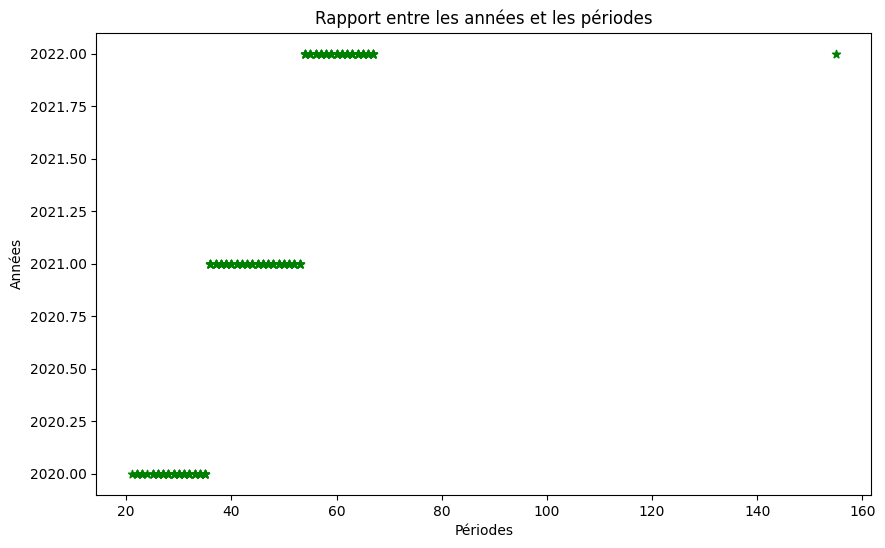

In [74]:
plt.figure(figsize=(10, 6))
plt.scatter(df_copy['time_period'], df_copy['Start date'].dt.year, color='green', marker='*')
plt.title('Rapport entre les années et les périodes')
plt.xlabel('Périodes')
plt.ylabel('Années')
plt.show()

In [75]:
min_periods = df_copy.groupby(df_copy['Start date'].dt.year)['time_period'].min()
max_periods = df_copy.groupby(df_copy['Start date'].dt.year)['time_period'].max()

df_periods = pd.concat([min_periods, max_periods], axis=1)
df_periods.columns = ['min_period', 'max_period']
df_periods = df_periods.reset_index()
df_periods['Start date'] = pd.to_datetime(df_periods['Start date'], format='%Y')
df_periods	

,Start date,min_period,max_period
0,2020-01-01,21,35
1,2021-01-01,36,53
2,2022-01-01,54,155


In [76]:
def handle_year(dataset, df_period):
    for index, row in dataset.iterrows():
        if pd.notna(row['Start date']):
            start_date = pd.to_datetime(row['Start date'], errors='coerce')
            if pd.isna(start_date):  # Handle non-standard date formats
                start_date = parse(row['Start date'])
            if start_date.year > 2022:
                matching_period = df_period[
                    (df_period['min_period'] <= row['time_period']) & (df_period['max_period'] >= row['time_period'])]
                if not matching_period.empty:
                    new_year = matching_period.iloc[0]['Start date'].year
                    dataset.at[index, 'Start date'] = start_date.replace(year=new_year).strftime('%Y-%m-%d')
                    if pd.notna(row['end date']):
                        end_date = pd.to_datetime(row['end date'], errors='coerce')
                        if pd.isna(end_date):  # Handle non-standard date formats for 'end date'
                            end_date = parse(row['end date'])
                        dataset.at[index, 'end date'] = end_date.replace(year=new_year).strftime('%Y-%m-%d')

    return dataset

# Apply the handle_year function
df = handle_year(df, df_periods)

In [77]:
def standardize_date(date_str):
    try:
        # Try parsing as a standard date format
        parsed_date = pd.to_datetime(date_str, errors='raise')
        return parsed_date.strftime('%Y-%m-%d')
    except ValueError:
        try:
            # Try parsing using dateutil.parser
            parsed_date = parse(date_str)
            return parsed_date.strftime('%Y-%m-%d')
        except ValueError:
            return date_str

# Apply the standardize_date function to 'Start date' and 'end date'
df['Start date'] = df['Start date'].apply(standardize_date)
df['end date'] = df['end date'].apply(standardize_date)

# Apply the handle_year function
df = handle_year(df, df_periods)
df

C:\Users\rachi\AppData\Local\Temp\ipykernel_11408\1508331135.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Start date'] = df['Start date'].apply(standardize_date)
C:\Users\rachi\AppData\Local\Temp\ipykernel_11408\1508331135.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end date'] = df['end date'].apply(standardize_date)


,zcta,time_period,population,Start date,end date,case count,test count,positive tests,case rate,test rate,positivity rate
0,95129,32,39741,2020-10-11,2020-10-31,22.0,2543.0,23.0,2.6,304.7,0.9
1,95129,40,39741,2021-03-28,2021-04-17,34.0,4816.0,37.0,4.1,577.1,0.8
2,95129,55,39741,2022-02-06,2022-02-26,110.0,10194.0,175.0,13.2,1221.5,1.7
3,95129,44,39741,2021-06-20,2021-07-10,14.0,3033.0,17.0,1.7,363.4,0.6
4,95129,54,39741,2022-01-16,2022-02-05,624.0,13479.0,817.0,74.8,1615.1,6.1
...,...,...,...,...,...,...,...,...,...,...,...
298,94085,59,23223,2022-05-01,2022-05-21,165.0,2315.0,192.0,33.8,474.7,8.3
299,94085,63,23223,2022-07-24,2022-08-13,150.0,1348.0,190.0,30.8,276.4,14.1
300,94085,61,23223,2022-06-12,2022-07-02,219.0,1696.0,255.0,44.9,347.8,15.0
301,94085,27,23223,2020-06-28,2020-07-18,53.0,1379.0,61.0,10.9,282.8,4.4


In [78]:
def median_outliers(column_name, values, min_threshold, max_threshold):
    '''
    Handling outliers by replacing them with the mean of the column
    '''
    numeric_columns = ['time_period', 'population', 'case count', 'test count', 'positive tests', 'case rate', 'test rate', 'positivity rate']
    if column_name in numeric_columns:
        med = values.mean()
        values = values.copy()  # Create a copy to avoid SettingWithCopyWarning
        values[values > max_threshold] = med
        values[values < min_threshold] = med

    return values

def handle_outlier(dataset):
    '''
    Handling outliers by replacing them with the mean of the column
    '''
    # Save the date columns to affect them later 
    date_columns = ['Start date', 'end date']
    for column in dataset.columns:
        if column not in date_columns:
            # Convert the column to numeric if it's not already
            dataset[column] = pd.to_numeric(dataset[column], errors='coerce')

            Q1 = dataset[column].quantile(0.25)
            Q3 = dataset[column].quantile(0.75)
            IQR = Q3 - Q1
            min_threshold = Q1 - 1.5 * IQR
            max_threshold = Q3 + 1.5 * IQR
            dataset[column] = median_outliers(column, dataset[column], min_threshold, max_threshold)

    # Affect the date columns with the original values
    for column in date_columns:
        dataset[column] = dataset[column].astype(str)

    return dataset

In [79]:
#handle outliers
df_filtered = df.copy(deep=True)
df_filtered = handle_outlier(df_filtered)
df_filtered

,zcta,time_period,population,Start date,end date,case count,test count,positive tests,case rate,test rate,positivity rate
0,95129,32.0,39741,2020-10-11,2020-10-31,22.00000,2543.000000,23.000000,2.600000,304.700000,0.900000
1,95129,40.0,39741,2021-03-28,2021-04-17,34.00000,4816.000000,37.000000,4.100000,577.100000,0.800000
2,95129,55.0,39741,2022-02-06,2022-02-26,110.00000,10194.000000,175.000000,13.200000,495.768543,1.700000
3,95129,44.0,39741,2021-06-20,2021-07-10,14.00000,3033.000000,17.000000,1.700000,363.400000,0.600000
4,95129,54.0,39741,2022-01-16,2022-02-05,232.65894,5211.334437,273.956954,21.570199,495.768543,6.100000
...,...,...,...,...,...,...,...,...,...,...,...
298,94085,59.0,23223,2022-05-01,2022-05-21,165.00000,2315.000000,192.000000,33.800000,474.700000,8.300000
299,94085,63.0,23223,2022-07-24,2022-08-13,150.00000,1348.000000,190.000000,30.800000,276.400000,14.100000
300,94085,61.0,23223,2022-06-12,2022-07-02,219.00000,1696.000000,255.000000,44.900000,347.800000,5.128808
301,94085,27.0,23223,2020-06-28,2020-07-18,53.00000,1379.000000,61.000000,10.900000,282.800000,4.400000


# **Visualisation:**


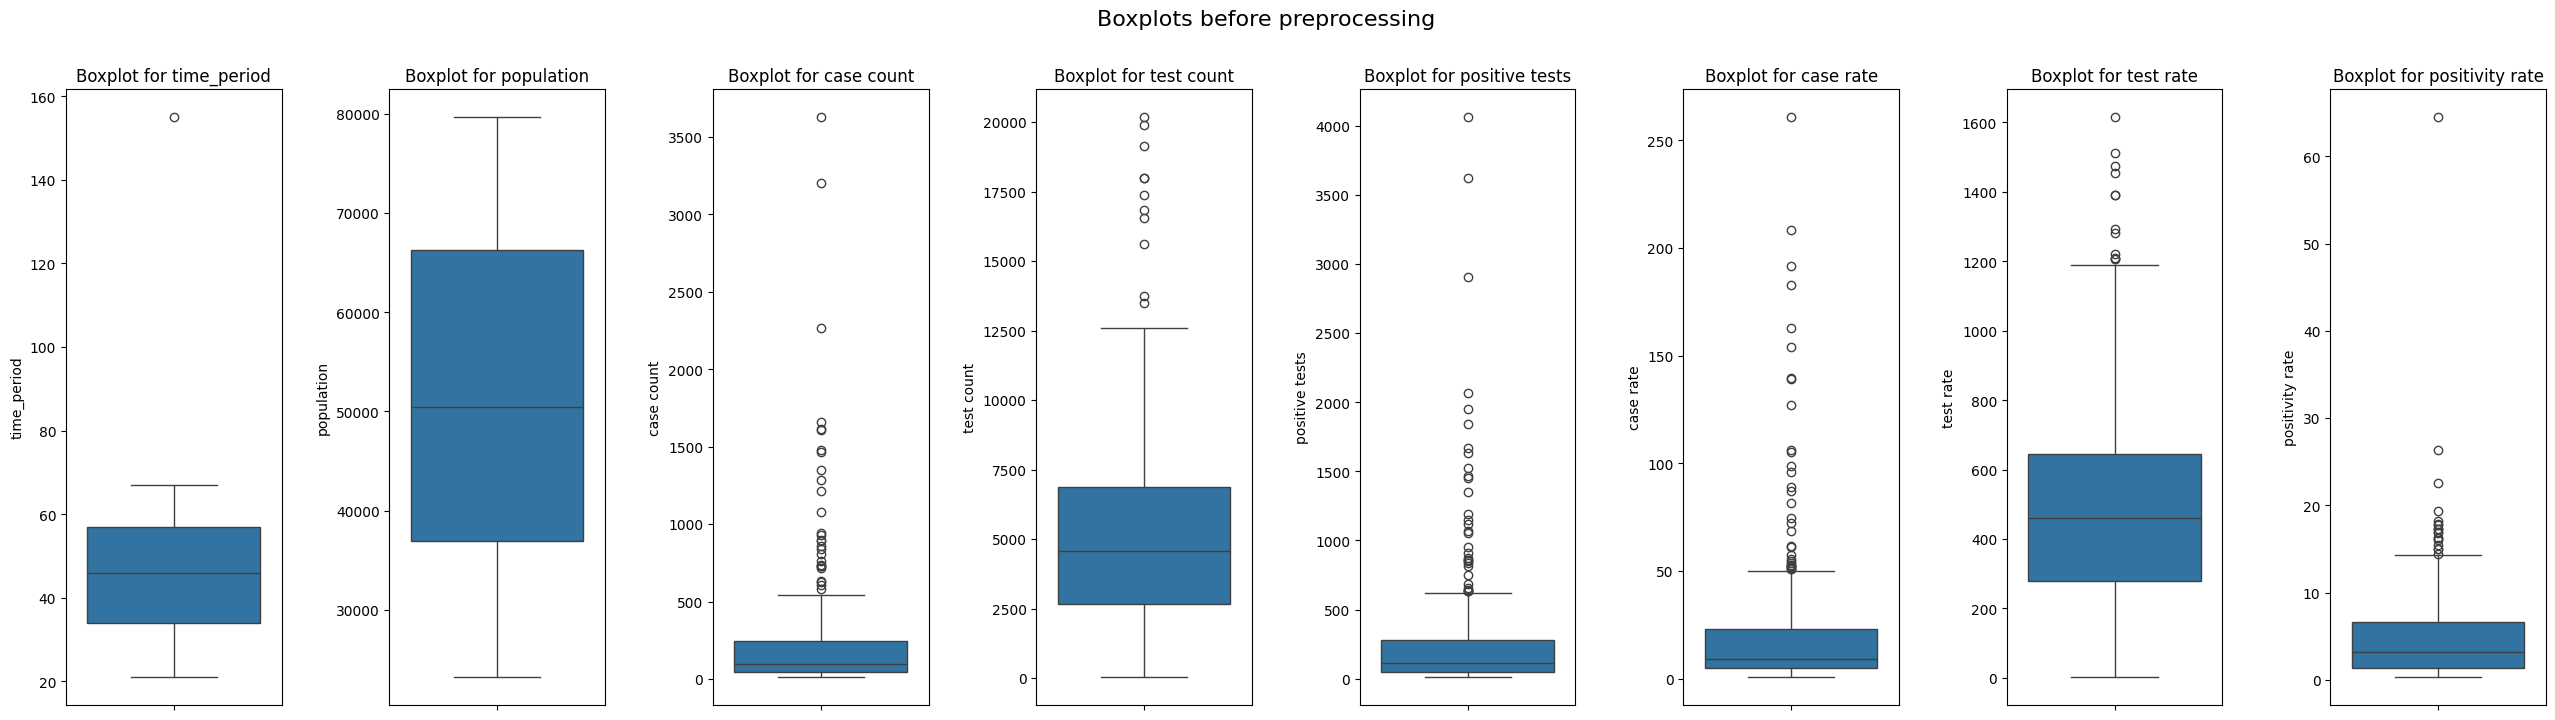

In [80]:
numeric_col = ['time_period', 'population', 'case count', 'test count', 'positive tests', 'case rate', 'test rate', 'positivity rate']

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_col), figsize=(4 * len(numeric_col), 8))
fig.subplots_adjust(wspace=0.5)  # Adjust horizontal space between subplots

#giving general title 
fig.suptitle('Boxplots before preprocessing', fontsize=16)

# Plot vertical box plots for each numeric column
for i, col in enumerate(numeric_col):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot for {col}')

plt.show()

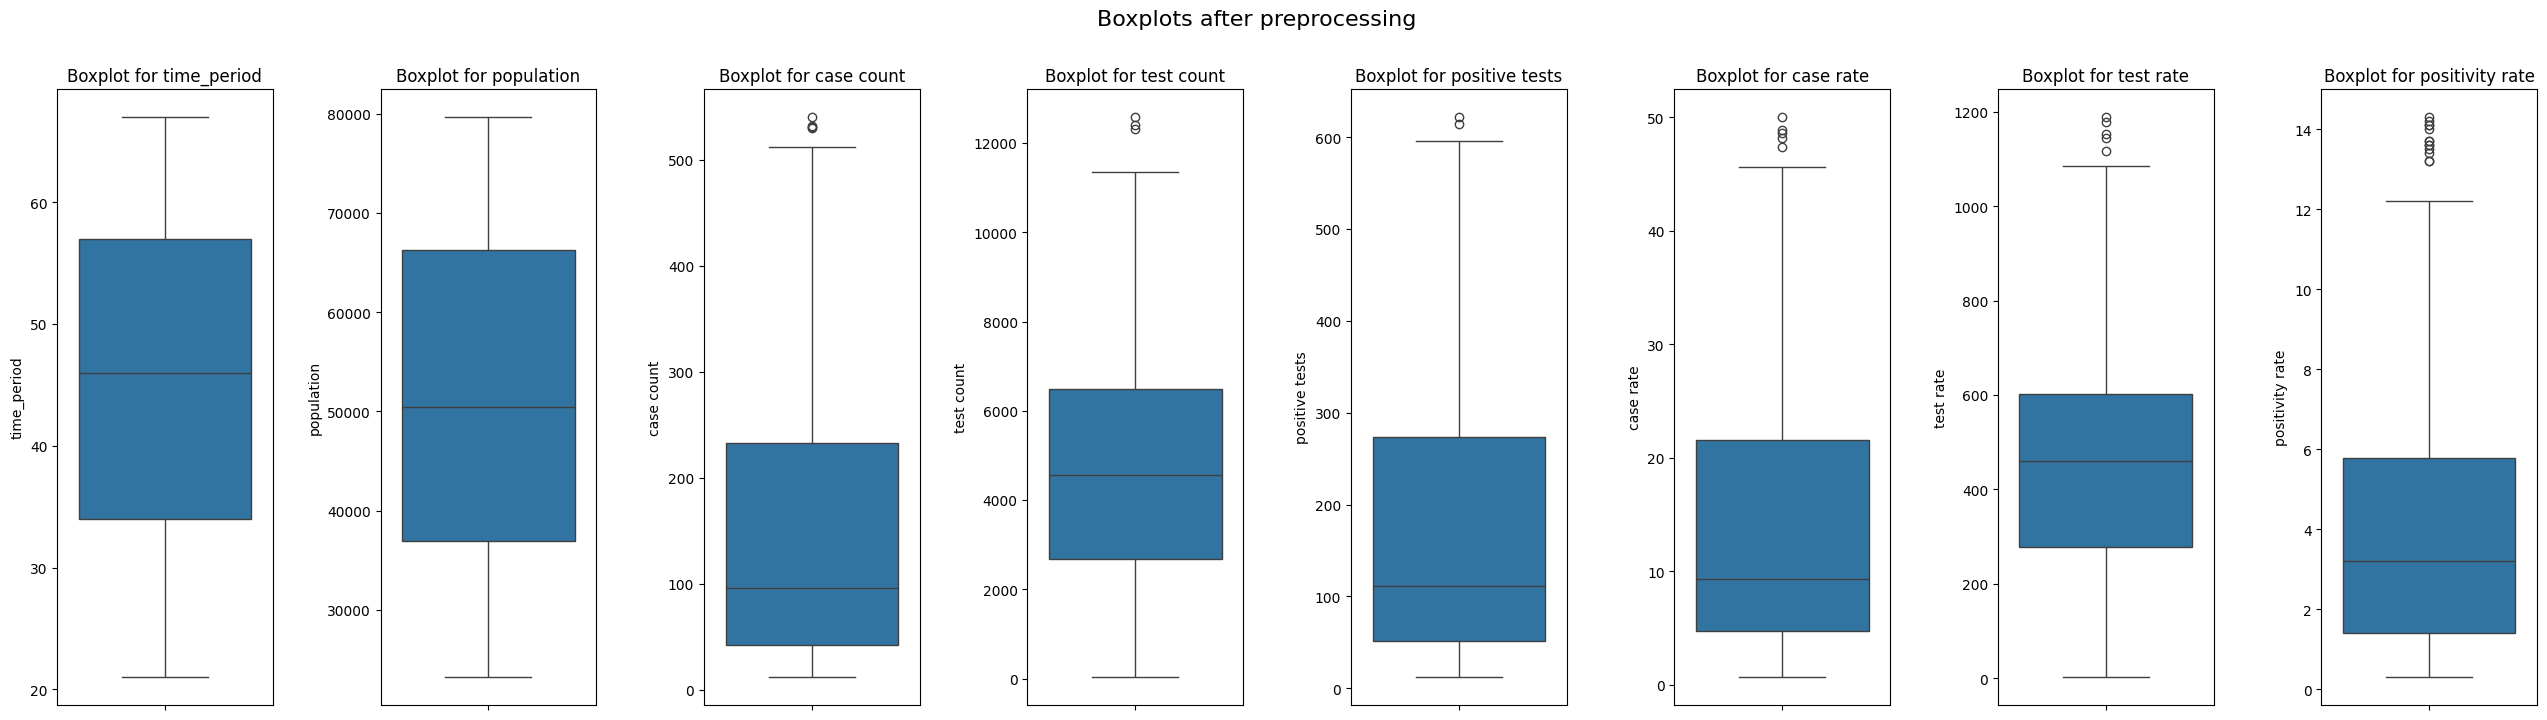

In [81]:
# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_col), figsize=(4 * len(numeric_col), 8))
fig.subplots_adjust(wspace=0.5)  
fig.suptitle('Boxplots after preprocessing', fontsize=16)
for i, col in enumerate(numeric_col):
    sns.boxplot(y=df_filtered[col], ax=axes[i])
    axes[i].set_title(f'Boxplot for {col}')

plt.show()

# La distribution du nombre total des cas confirmés et tests positifs par zones

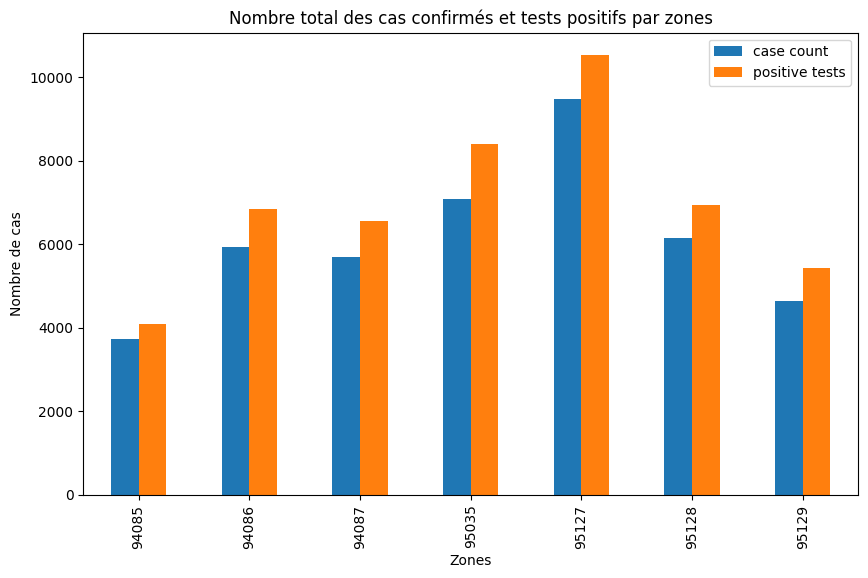

In [82]:
df_filtered.groupby('zcta').sum()[['case count', 'positive tests']].plot(kind='bar', figsize=(10, 6))
plt.title('Nombre total des cas confirmés et tests positifs par zones')
plt.ylabel('Nombre de cas')
plt.xlabel('Zones')
plt.show()

# les tests positifs et le nombre de cas évolue au fil du temps (hebdomadaire, mensuel et annuel) pour une zone choisit

C:\Users\rachi\AppData\Local\Temp\ipykernel_11408\844444680.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zone['Start date'] = pd.to_datetime(df_zone['Start date'])


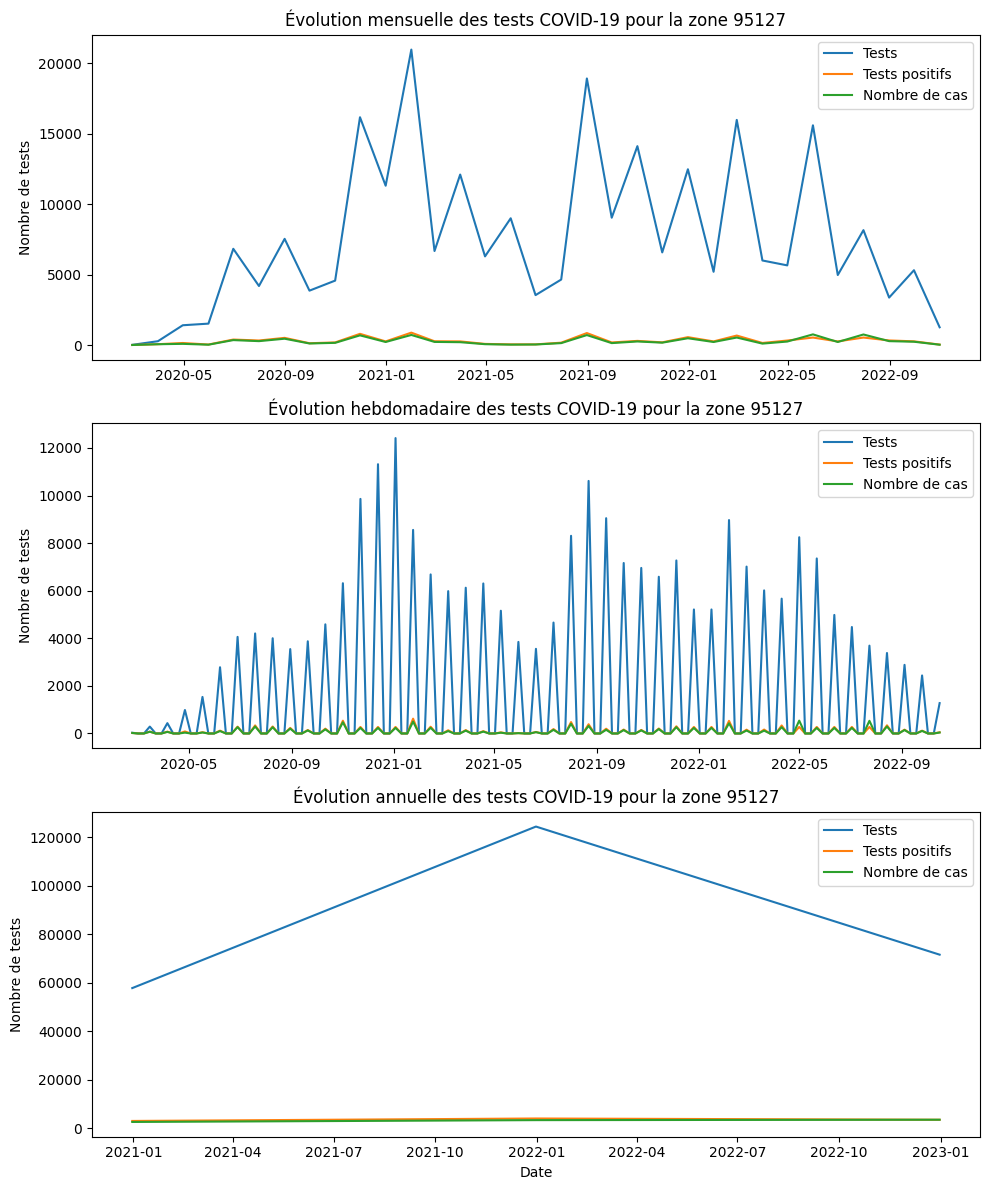

In [84]:
zone_choisie = 95127

# Filtrer le dataframe pour la zone choisie
df_zone = df_filtered[df_filtered['zcta'] == zone_choisie]

# Convertir les colonnes 'Start date' en datetime
df_zone['Start date'] = pd.to_datetime(df_zone['Start date'])

# Trier le dataframe par 'Start date'
df_zone = df_zone.sort_values(by='Start date')

# Créer trois sous-graphiques avec subplots
plt.figure(figsize=(10, 12))

# Évolution mensuelle
plt.subplot(3, 1, 1)
df_monthly = df_zone.resample('M', on='Start date').sum()
plt.plot(df_monthly.index, df_monthly['test count'], label='Tests')
plt.plot(df_monthly.index, df_monthly['positive tests'], label='Tests positifs')
plt.plot(df_monthly.index, df_monthly['case count'], label='Nombre de cas')
plt.title(f'Évolution mensuelle des tests COVID-19 pour la zone {zone_choisie}')
plt.ylabel('Nombre de tests')
plt.legend()

# Évolution hebdomadaire
plt.subplot(3, 1, 2)
df_weekly = df_zone.resample('W', on='Start date').sum()
plt.plot(df_weekly.index, df_weekly['test count'], label='Tests')
plt.plot(df_weekly.index, df_weekly['positive tests'], label='Tests positifs')
plt.plot(df_weekly.index, df_weekly['case count'], label='Nombre de cas')
plt.title(f'Évolution hebdomadaire des tests COVID-19 pour la zone {zone_choisie}')
plt.ylabel('Nombre de tests')
plt.legend()

# Évolution annuelle
plt.subplot(3, 1, 3)
df_yearly = df_zone.resample('Y', on='Start date').sum()
plt.plot(df_yearly.index, df_yearly['test count'], label='Tests')
plt.plot(df_yearly.index, df_yearly['positive tests'], label='Tests positifs')
plt.plot(df_yearly.index, df_yearly['case count'], label='Nombre de cas')
plt.title(f'Évolution annuelle des tests COVID-19 pour la zone {zone_choisie}')
plt.xlabel('Date')
plt.ylabel('Nombre de tests')
plt.legend()

# Afficher les graphiques
plt.tight_layout()
plt.show()

# Répartition des cas positifs de COVID-19 par zone et par année

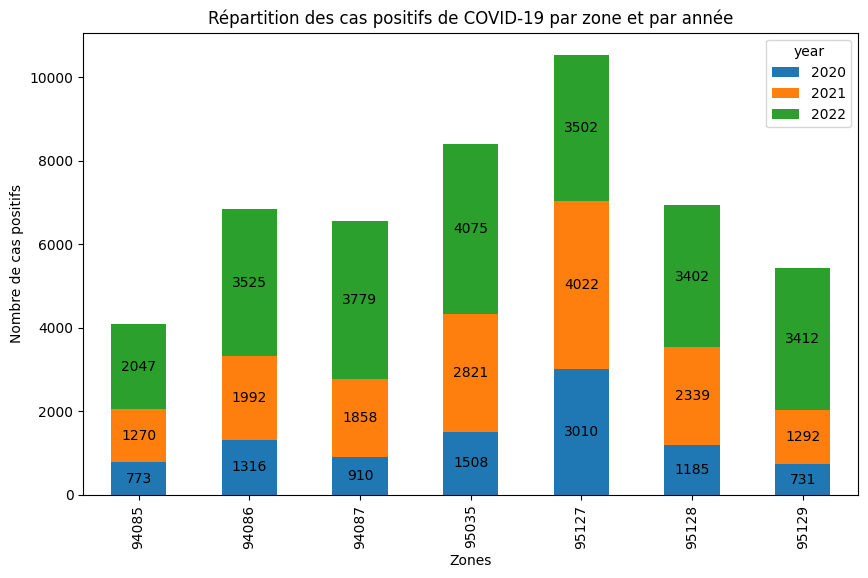

In [85]:
df_filtered['Start date'] = pd.to_datetime(df_filtered['Start date'], errors='coerce')
df_filtered['year'] = df_filtered['Start date'].dt.year

stacked_data = df_filtered.groupby(['zcta', 'year'])['positive tests'].sum().unstack()
ax = stacked_data.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Répartition des cas positifs de COVID-19 par zone et par année')
plt.ylabel('Nombre de cas positifs')
plt.xlabel('Zones')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x + width / 2, y + height / 2, int(height), horizontalalignment='center', verticalalignment='center')

plt.show()

# Rapport entre la population et le nombre de tests effectués

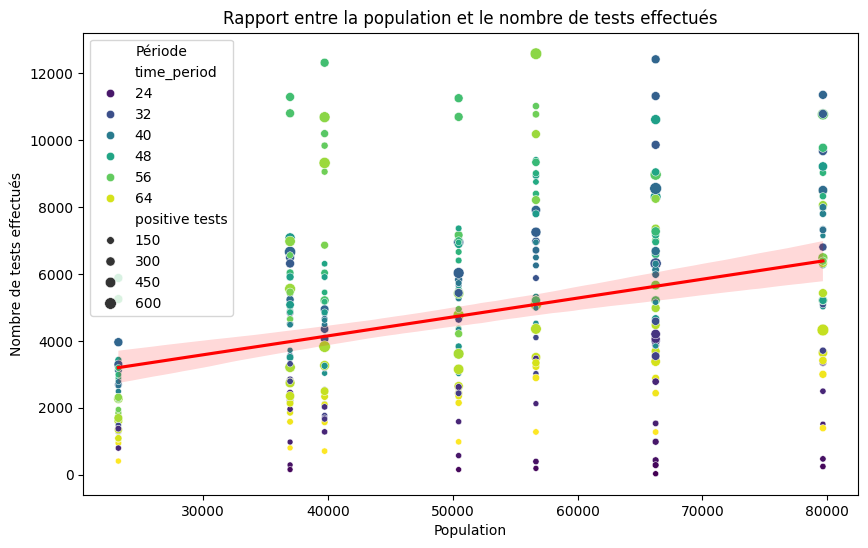

In [86]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x='population', y='test count', hue='time_period', palette='viridis', size='positive tests')

# Ajouter une ligne de régression linéaire qui représente la relation entre la population et le nombre de tests effectués
sns.regplot(data=df_filtered, x='population', y='test count', scatter=False, color='red') 
plt.title('Rapport entre la population et le nombre de tests effectués')
plt.xlabel('Population')
plt.ylabel('Nombre de tests effectués')
plt.legend(title='Période')
plt.show()

# Top 5 zones les plus touchées par COVID-19

In [87]:
zone_impact = df_filtered.groupby('zcta')['positive tests'].sum()
#sorting the values in descending order
zone_impact_sorted = zone_impact.sort_values(ascending=False)
# Get the top 5 zones with the highest total positive tests
top_5_zones = zone_impact_sorted.head(5)
# Display the result
print("Top 5 Zones Most Heavily Impacted by COVID-19:")
print(top_5_zones)

Top 5 Zones Most Heavily Impacted by COVID-19:
zcta
95127    10536.569536
95035     8406.612583
95128     6928.827815
94086     6834.913907
94087     6548.870861
Name: positive tests, dtype: float64


Text(0.5, 0, 'Zones')

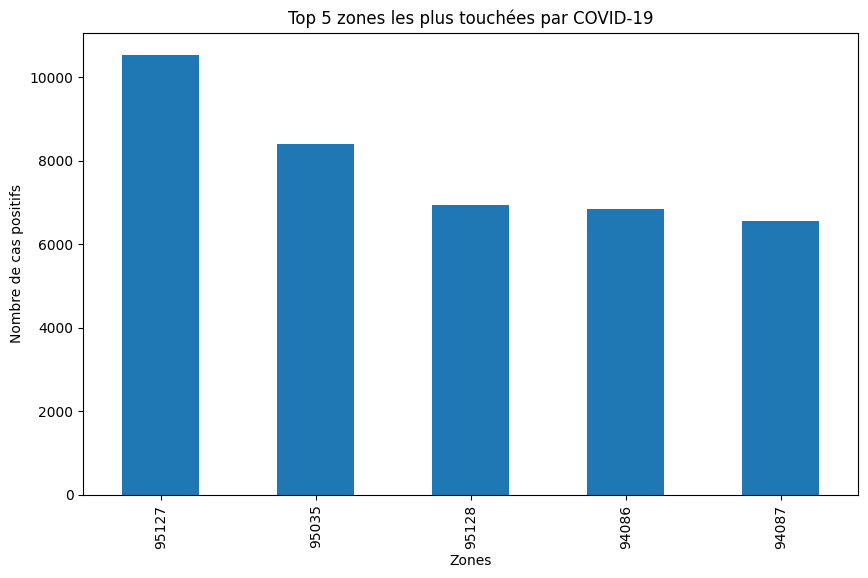

In [88]:
#bar chart
zone_impact_sorted.head(5).plot(kind='bar', figsize=(10, 6))
plt.title('Top 5 zones les plus touchées par COVID-19')
plt.ylabel('Nombre de cas positifs')
plt.xlabel('Zones')

# cas confirmés, tests effectués et tests positifs pour la période

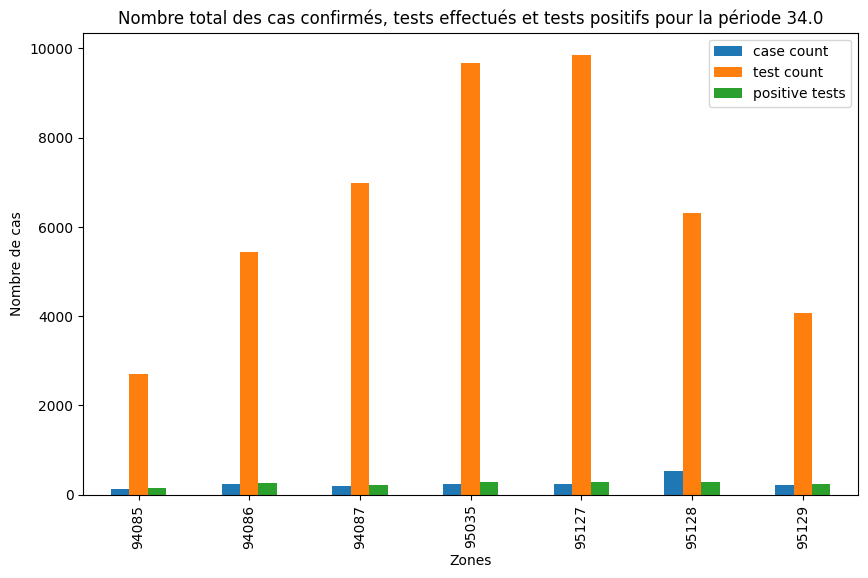

In [89]:
# Choisir la période que vous souhaitez analyser
selected_period = 34.0
# Filtrer les données pour la période sélectionnée
period_data = df_filtered[df_filtered['time_period'] == selected_period]
# Exclude datetime columns from sum operation
numeric_columns = ['case count', 'test count', 'positive tests']
grouped_data = period_data.groupby('zcta')[numeric_columns].sum()
# Bar chart for case count, test count, positive tests by zone
grouped_data.plot(kind='bar', figsize=(10, 6))
plt.title(f'Nombre total des cas confirmés, tests effectués et tests positifs pour la période {selected_period}')
plt.ylabel('Nombre de cas')
plt.xlabel('Zones')
plt.show()

# **RATIO**

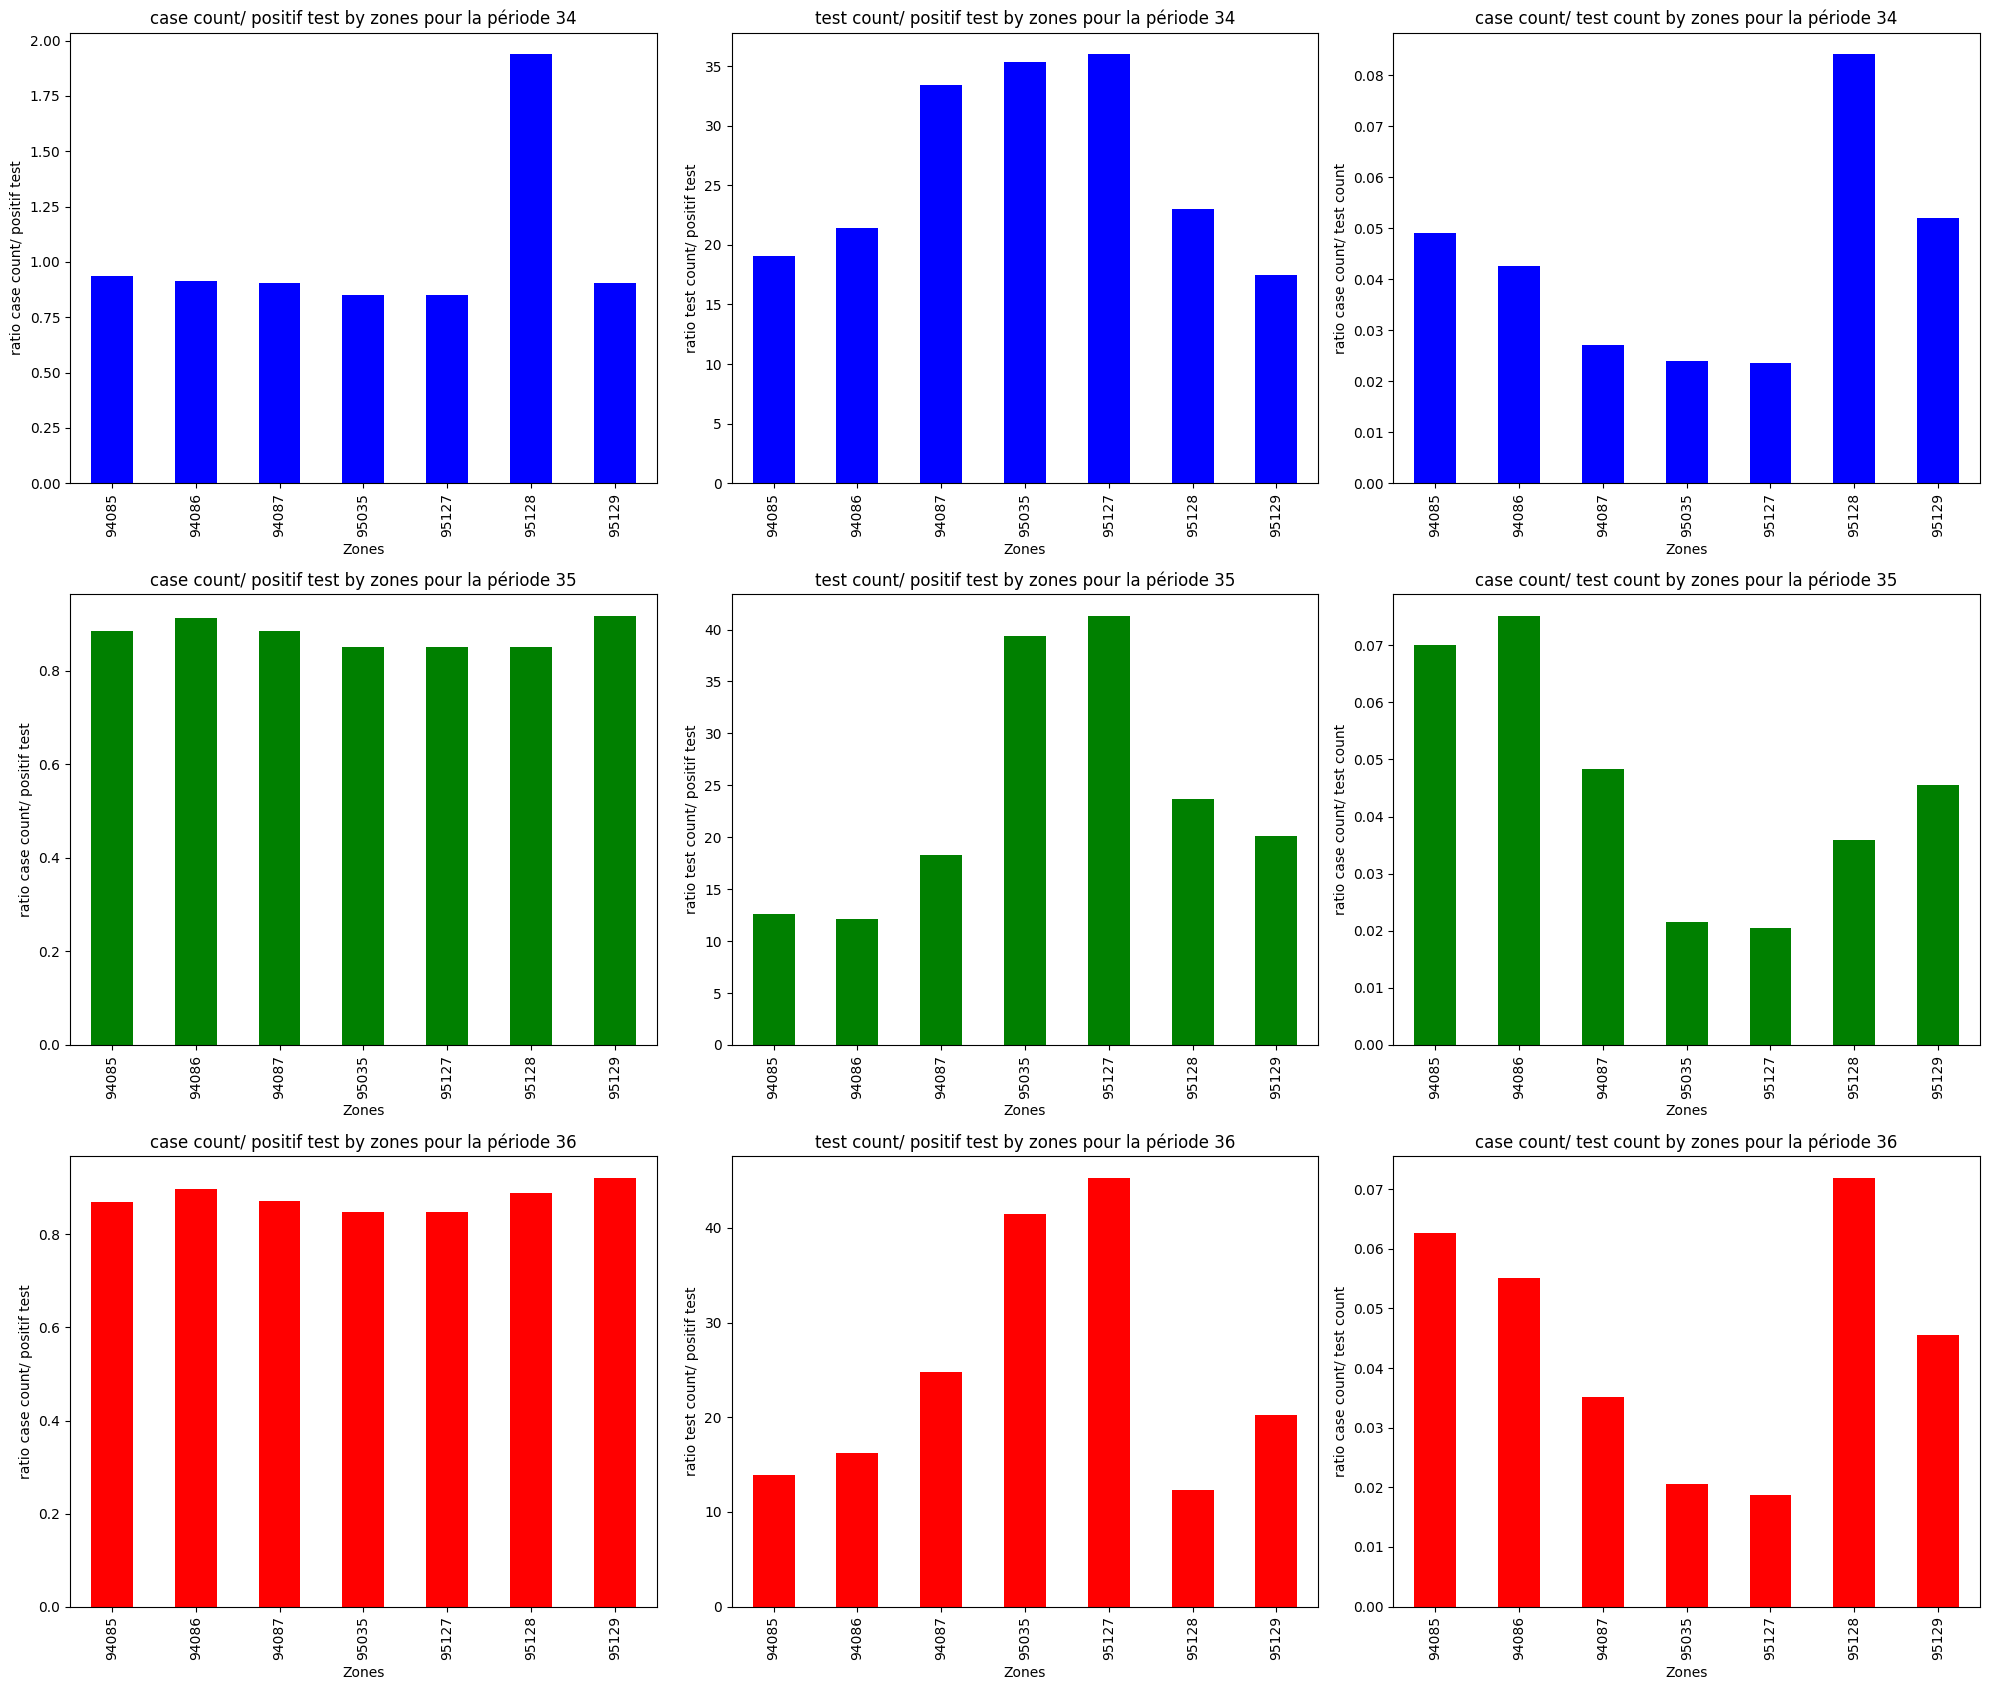

In [90]:
colors = ['blue', 'green', 'red', 'brown', 'black']
# Choisir la période que vous souhaitez analyser
selected_period = ['34', '35', '36']
# Exclude datetime columns from sum operation
numeric_columns = ['case count', 'test count', 'positive tests']

# Create a figure with a 5x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(20, 17))

# Iterate over selected periods
for i in range(0, len(selected_period)):
    period_data = df_filtered[df_filtered['time_period'] == int(selected_period[i])]
    grouped_data = period_data.groupby('zcta')[numeric_columns].sum()
    grouped_data['case count'].div(grouped_data['positive tests']).plot(kind='bar', color=colors[i], ax=axs[i, 0])
    axs[i, 0].set_title(f'case count/ positif test by zones pour la période {selected_period[i]}')
    axs[i, 0].set_ylabel('ratio case count/ positif test')
    axs[i, 0].set_xlabel('Zones')

    # grouping the data by zone and dividing the sum of test count by positive tests
    grouped_data['test count'].div(grouped_data['positive tests']).plot(kind='bar', color=colors[i], ax=axs[i, 1])
    axs[i, 1].set_title(f'test count/ positif test by zones pour la période {selected_period[i]}')
    axs[i, 1].set_ylabel('ratio test count/ positif test')
    axs[i, 1].set_xlabel('Zones')

    # grouping the data by zone and dividing the sum of case count by test count
    grouped_data['case count'].div(grouped_data['test count']).plot(kind='bar', color=colors[i], ax=axs[i, 2])
    axs[i, 2].set_title(f'case count/ test count by zones pour la période {selected_period[i]}')
    axs[i, 2].set_ylabel('ratio case count/ test count')
    axs[i, 2].set_xlabel('Zones')

plt.tight_layout()
plt.show()


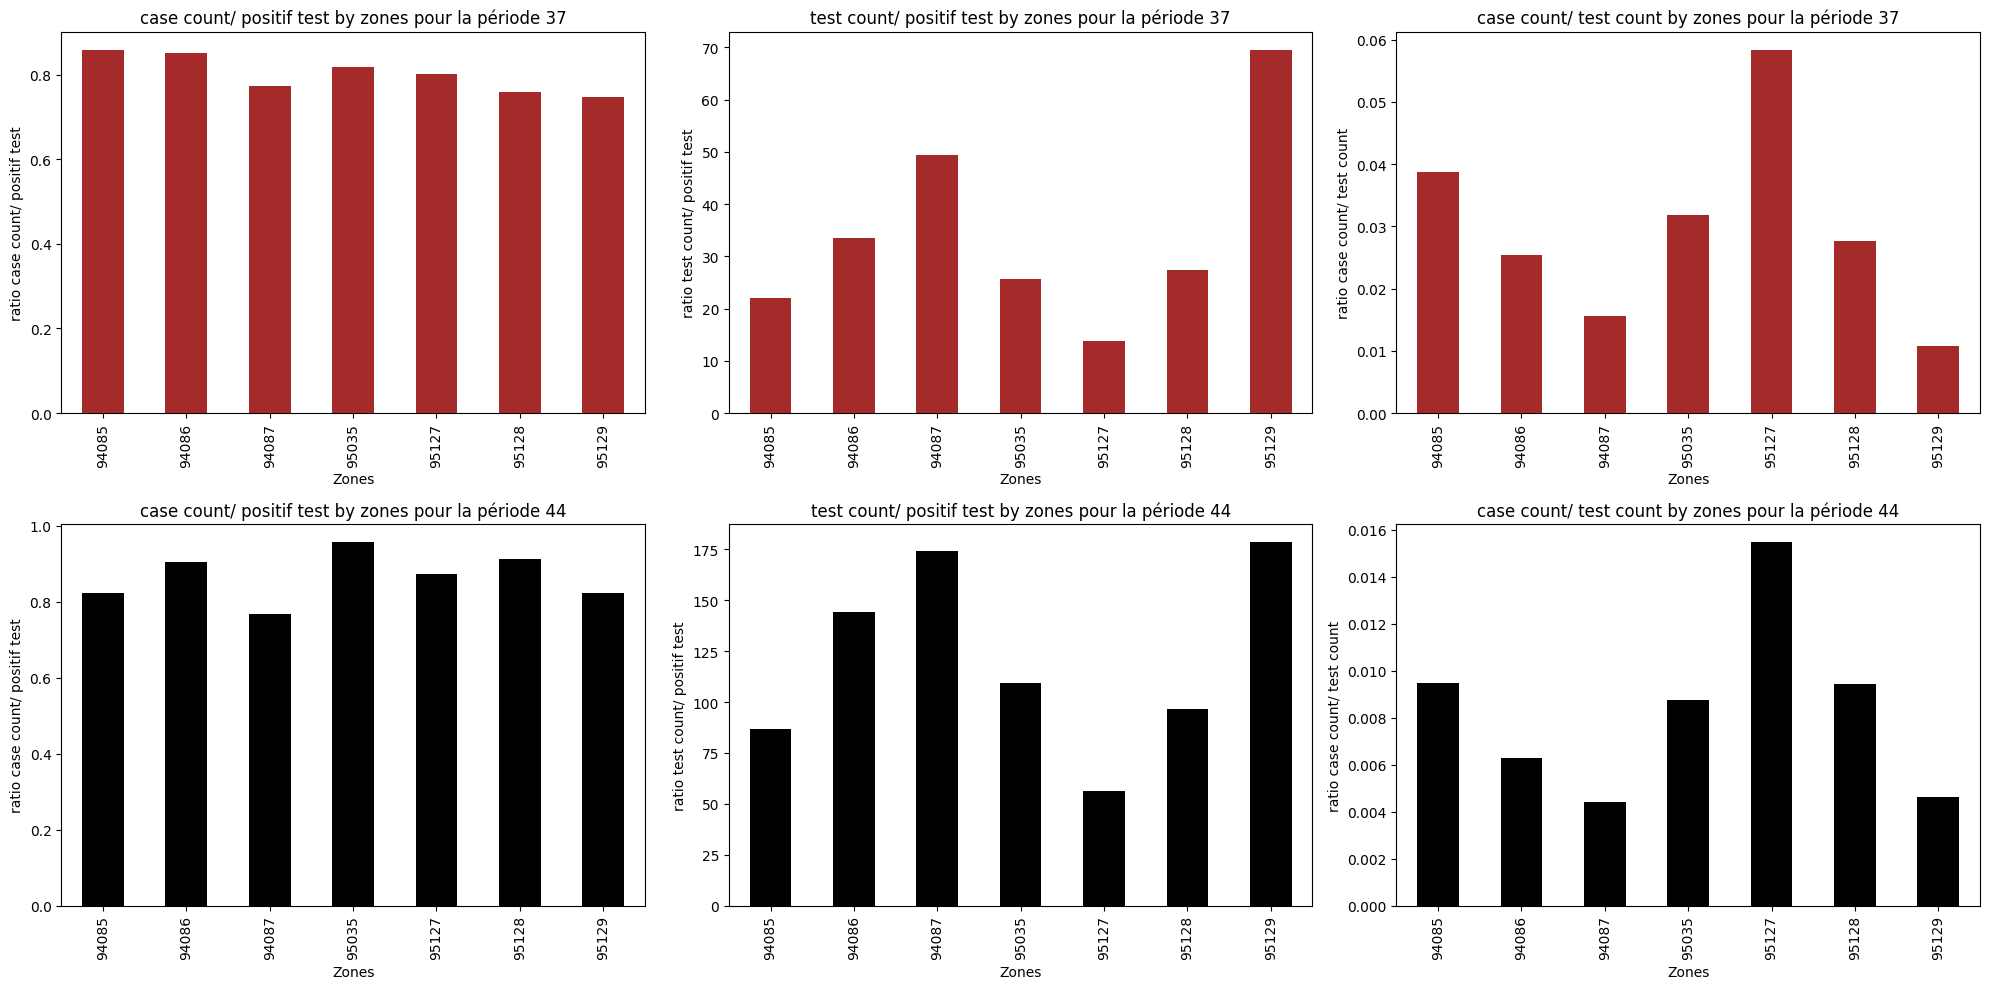

In [91]:
colors = ['brown', 'black']
# Choisir la période que vous souhaitez analyser
selected_period = ['37', '44']
# Exclude datetime columns from sum operation
numeric_columns = ['case count', 'test count', 'positive tests']

# Create a figure with a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

# Iterate over selected periods
for i in range(0, len(selected_period)):
    period_data = df_filtered[df_filtered['time_period'] == int(selected_period[i])]
    grouped_data = period_data.groupby('zcta')[numeric_columns].sum()
    grouped_data['case count'].div(grouped_data['positive tests']).plot(kind='bar', color=colors[i], ax=axs[i, 0])
    axs[i, 0].set_title(f'case count/ positif test by zones pour la période {selected_period[i]}')
    axs[i, 0].set_ylabel('ratio case count/ positif test')
    axs[i, 0].set_xlabel('Zones')

    # grouping the data by zone and dividing the sum of test count by positive tests
    grouped_data['test count'].div(grouped_data['positive tests']).plot(kind='bar', color=colors[i], ax=axs[i, 1])
    axs[i, 1].set_title(f'test count/ positif test by zones pour la période {selected_period[i]}')
    axs[i, 1].set_ylabel('ratio test count/ positif test')
    axs[i, 1].set_xlabel('Zones')

    # grouping the data by zone and dividing the sum of case count by test count
    grouped_data['case count'].div(grouped_data['test count']).plot(kind='bar', color=colors[i], ax=axs[i, 2])
    axs[i, 2].set_title(f'case count/ test count by zones pour la période {selected_period[i]}')
    axs[i, 2].set_ylabel('ratio case count/ test count')
    axs[i, 2].set_xlabel('Zones')

plt.tight_layout()
plt.show()
